<a href="https://colab.research.google.com/github/satoruk-icepp/MEG2XEC/blob/master/EnergyRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch comet_ml
!pip install uproot
from comet_ml import Experiment

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data.dataset import Subset
from torch.optim.lr_scheduler import MultiStepLR,StepLR,CyclicLR,CosineAnnealingLR
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
%%writefile .comet.config
[comet]
api_key=mIel5ZAPOioTs0Cij75dSSQXs
logging_file = /tmp/comet.log
logging_file_level = info


Overwriting .comet.config


In [5]:
experiment = Experiment(project_name="EneReg",log_code=True)
curtime = datetime.now().strftime("%Y%m%d-%H%M%S")
experiment.set_name("%s"%(curtime))
params={'batch_size' : 200,
        # 'train_size':20000,
        'val_size':500,
        # 'dropout_conv':0.3,
        'dropout_fc':0.0,
        'optim':"Adam",
        'weight_decay':1e-05,
        # 'Nresblock':0,
        # 'Nsd':0,
        # 'Wthreshold':np.log(0.2+1e-02)/2.5+1,
        # 'ethreshold':0.0,
        'weightstd':0.01,
        'NphoScale':10000,
        # 'Nfcnodes':128,
        'Nepoch':4000,
        # 'learning_rate':0.0000001,# for lr_test
        # 'LRgamma':10,# for lr_test
        # 'stepsize_lr':1, # for lr_test
        "LRtype":"Step",
        'learning_rate':0.01,
        # 'LRgamma':0.3,
        # 'LRgamma':0.5,
        'LRgamma':0.998,
        'milestones':[200,500,2000,5000,20000],
        # "LRtype":"MStep",
        # "LRtype":"Cyclic",
        # "LRtype":"CosA",
        # "LRtype":"CosExp",
        'stepsize_lr':1,
        'stepsize_lr_down':29,
        
        'base_lr':0.000001,
        'Erange':[15,20],
        'Urange':[-8,8],
        'Vrange':[-25,-5],
        'Wrange':[2,10],
        # 'max_lr':0.005,
        
        # 'UseLPF':False,
        # 'DoBlind':False
}
experiment.log_parameters(params)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/satoruk-icepp/enereg/f3e59e108e7d43269f134a803d96ff23



In [0]:
import uproot
file = uproot.open("/content/drive/My Drive/MEG2CW/Gamma353640.root")
tout = file["tGamma"]

In [7]:
tout.keys()

[b'uvw',
 b'uvwlpf',
 b'nphoarray',
 b'qmppcsumwf',
 b'qpmtsumwf',
 b'nsum2',
 b'npmt2',
 b'ninner2',
 b'energy']

In [0]:
energy_raw = tout.array("energy")
npho_raw = tout.array("nphoarray")
uvwlpf = tout.array("uvwlpf")

npho_raw = npho_raw/params["NphoScale"]
indx_ene = (energy_raw<params["Erange"][1]) & (energy_raw>params["Erange"][0])
indx_pos =(uvwlpf[:,2]>params["Wrange"][0])\
&(uvwlpf[:,2]<params["Wrange"][1]) \
& (uvwlpf[:,1]>params["Vrange"][0])\
& (uvwlpf[:,1]<params["Vrange"][1])\
& (uvwlpf[:,0]>params["Urange"][0])\
& (uvwlpf[:,0]<params["Urange"][1])
indx = indx_ene & indx_pos
# indx = (energy_raw<20) & (energy_raw>17) &  (uvwlpf[:,2]<10)
energy = energy_raw[indx]
npho = npho_raw[indx]

(array([[ 7., 12.,  9., ...,  8.,  9.,  7.],
        [ 7., 11.,  8., ...,  6.,  6.,  4.],
        [ 8.,  8.,  9., ...,  8.,  9., 11.],
        ...,
        [12., 12.,  9., ..., 11.,  6.,  9.],
        [ 9.,  8., 10., ..., 12.,  9.,  7.],
        [ 6., 13., 13., ...,  3.,  8.,  0.]]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
          8. ,   8.4,   8.8,   9.2,   9.6,  10. ]),
 array([-30. , -29.4, -28.8, -28.2, -27.6, -27. , -26.4, -25.8, -25.2,
        -24.6, -24. , -23.4, -22.8, -22.2, -21.6, -21. , -20.4, -19.8,
        -19.2, -18.6, -18. , -17.4, -16.8, -16.2, -15.6, -15. , -14.4,
        -13.8, -13.2, -12.6, -12. , -11.4, -10.8, -10.2,  -9.6,  -9. ,
         -8.4,  -7.8,  -

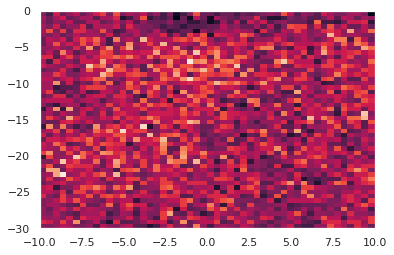

In [9]:
plt.hist2d(uvwlpf[:,0],uvwlpf[:,1],bins=[50,50],range=[[-10,10],[-30,0]])

8.692727894139688


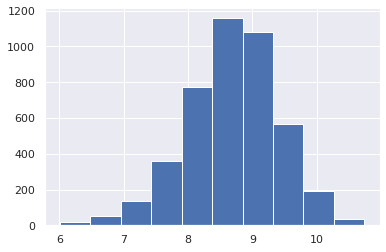

In [10]:
plt.hist(npho.sum(axis=1))
print(npho.sum(axis=1).mean())

(array([ 99., 103., 130., 126., 174., 196., 219., 216., 278., 239., 273.,
        303., 253., 268., 255., 226., 204., 162., 160., 130.,  85.,  73.,
         53.,  40.,  29.,  22.,  16.,  11.,   5.,   2.,   4.,   4.,   3.,
          1.,   1.,   2.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.]),
 array([15.00007265, 15.09789751, 15.19572236, 15.29354722, 15.39137208,
        15.48919694, 15.58702179, 15.68484665, 15.78267151, 15.88049637,
        15.97832122, 16.07614608, 16.17397094, 16.2717958 , 16.36962065,
        16.46744551, 16.56527037, 16.66309523, 16.76092008, 16.85874494,
        16.9565698 , 17.05439466, 17.15221951, 17.25004437, 17.34786923,
        17.44569409, 17.54351894, 17.6413438 , 17.73916866, 17.83699352,
        17.93481837, 18.03264323, 18.13046809, 18.22829295, 18.3261178 ,
        18.42394266, 18.52176752, 18.61959238, 18.71741723, 18.81524209,
        18.91306695, 19.01089181, 19.10871666, 19.20654152, 19.30436638,
 

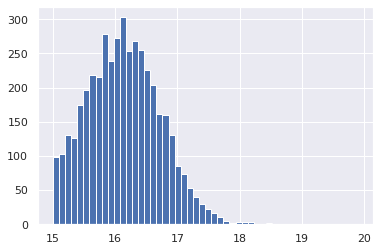

In [11]:
plt.hist(energy,bins=50)

In [0]:
def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.normal_(mean, std)
        if m.bias is not None:
            if m.bias.data is not None:
                m.bias.data.zero_()

In [0]:
class reg(nn.Module):
    def __init__(self,dropout=0):
        super(reg,self).__init__()
        self.linear = nn.Linear(4760,1,False)
        self.dropout = nn.Dropout(dropout);

    def forward(self,x):
        x = self.linear(self.dropout(x))
        return x

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [0]:
# reg = nn.Sequential(nn.Linear(2, 1,False))
loss_fn = torch.nn.SmoothL1Loss().to(device)

In [0]:
model = reg(params["dropout_fc"]).to(device)
model.weight_init(mean=1e-04,std=1e-05)
opt = optim.Adam(model.parameters(), lr=params["learning_rate"])
if params["LRtype"]=="Cyclic":
    scheduler = CyclicLR(opt, params["base_lr"],params["learning_rate"],
                         step_size_up=params["stepsize_lr"],
                         step_size_down=params["stepsize_lr_down"],
                         cycle_momentum=False,mode="exp_range",gamma = params["LRgamma"])
elif params["LRtype"]=="MStep":
    scheduler = MultiStepLR(opt, milestones=params["milestones"], gamma=params["LRgamma"])
elif params["LRtype"]=="Step":
    scheduler = StepLR(opt,step_size=params["stepsize_lr"],gamma=params["LRgamma"])
elif params["LRtype"]=="CosA":
    scheduler = CosineAnnealingLR(opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"])
# elif params["LRtype"]=="CosExp":
#     scheduler = CosineExpLR(opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"],gamma = params["LRgamma"])

In [0]:
energy = torch.tensor(energy).float()
npho = torch.tensor(npho).float()

In [17]:
BATCH_SIZE = params["batch_size"]
# BATCH_SIZE = 100
calo_dataset    = utils.TensorDataset(energy,npho)
data_size =  len(calo_dataset)
full_size = int(data_size//1000)*1000
val_size = params["val_size"]
print(data_size)
train_dataset = Subset(calo_dataset,list(range(0,full_size-val_size)))
val_dataset = Subset(calo_dataset,list(range(full_size-val_size,full_size)))
# train_dataset = Subset(calo_dataset,list(range(0,params["train_size"])))
# val_dataset = Subset(calo_dataset,list(range(params["train_size"],params["train_size"]+params["val_size"])))
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=len(val_dataset), 
                                              pin_memory=True, shuffle=True)

4370


In [0]:
# batch_size=10
ibatch = 0
for i in range(params["Nepoch"]):
    with experiment.train():
        model.train()
        for energy_b,npho_b in train_dataloader:
                # moving them to device(for example, cuda-device)
            energy_b,npho_b = energy_b.to(device), \
                            npho_b.to(device)
        # real_data = sample_real_data(batch_size)
            
            pred = model(npho_b)
            target = (torch.ones(pred.shape[0])*17.6).to(device)
            loss        = loss_fn(pred, target)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            # if ibatch%10==0: print(ibatch)
            ibatch +=1

        scheduler.step()
        experiment.log_metric("loss", loss.item(),step=i)
        experiment.log_metric("learning_rate", scheduler.get_lr(),step=i)

    with experiment.test():
        model.eval()
        for energy_b,npho_b in val_dataloader:
                # moving them to device(for example, cuda-device)
            energy_b,npho_b = energy_b.to(device), \
                            npho_b.to(device)
            pred = model(npho_b)
            target = (torch.ones(pred.shape[0])*17.6).to(device)
            val_loss        = loss_fn(pred, target)                
        experiment.log_metric("loss", val_loss.item(),step=i)


    if i%10==0:
        plt.hist(energy_b.cpu().detach().numpy(),bins=50,range=(15,20),histtype='step',fill=False,edgecolor='b',label='nsum2')
        plt.hist(pred.cpu().detach().numpy(),bins=50,range=(15,20),histtype='step',fill=False,edgecolor='r',label='pred')
        plt.legend(loc="upper left")
        experiment.log_figure(figure=plt)
        plt.close()
        
        
        
# print(loss.item(),pred,model.linear.weight)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:782: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:782: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:782: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.

In [0]:
model.eval()
pred_test = model.cpu()(torch.tensor(npho_raw).float())
# prediction_test = regressor.cpu()(torch.tensor(EnergyDeposit_test).float())

In [0]:
# indx_w = (uvwlpf[:,2]>2)&(uvwlpf[:,2]<5)&(uvwlpf[:,1]>-20)&(uvwlpf[:,1]<-10)
# indx_pos = (uvwlpf[:,2]>2) & (uvwlpf[:,2]<10) & (uvwlpf[:,1]<-10) & (uvwlpf[:,1]>-20) & (uvwlpf[:,0]>-5) & (uvwlpf[:,0]<5)
plt.hist(pred_test[indx_pos].cpu().detach().numpy(),range=(0,20),bins=100,histtype='step',fill=False,edgecolor='r',label='pred')
plt.hist(energy_raw[indx_pos],range=(0,20),bins=100,histtype='step',fill=False,edgecolor='b',label='raw')

In [0]:
print(uvwlpf[:,2].shape)
from matplotlib.colors import LogNorm
plt.hist2d(uvwlpf[indx_pos,2],pred_test[indx_pos,0].cpu().detach().numpy(),range=[[0,20],[0,20]],bins=[100,100],norm=LogNorm())
# plt.hist2d(uvwlpf[:,2],pred_test[:,0].cpu().detach().numpy(),range=[[0,20],[0,20]],bins=[100,100])

In [0]:
plt.hist2d(uvwlpf[:,1],pred_test[:,0].cpu().detach().numpy(),range=[[-40,0],[0,20]],bins=[100,100],norm=LogNorm())

In [0]:
plt.hist2d(uvwlpf[:,0],pred_test[:,0].cpu().detach().numpy(),range=[[-10,10],[0,20]],bins=[100,100],norm=LogNorm())

In [0]:
plt.hist2d(uvwlpf[:,2],energy_raw,range=[[0,40],[0,20]],bins=[100,100])

In [0]:
x = [i for i in range(4760)]
# v = []
print(model.linear.weight.cpu().detach().numpy())
# for param in model.parameters():
    # v.append(param.data[0])

# plt.scatter(x,model.linear.weight.cpu().detach().numpy(),vmin=-0.001,vmax=0.001,c="r")
plt.hist(model.linear.weight[0].cpu().detach().numpy(),range=(0,4e-4),bins=80)
    # for weight in param.data[0]:
    #     print(weight)

In [0]:
file_uslit = uproot.open("/content/drive/My Drive/MEG2CW/Gamma330471.root")
tout_uslit = file_uslit["tGamma"]

In [0]:
energy_uslit = tout_uslit.array("energy")
npho_uslit = tout_uslit.array("nphoarray")
uvwlpf_uslit = tout_uslit.array("uvwlpf")

npho_uslit = npho_uslit/params["NphoScale"]

In [0]:
indx_pos_uslit =(uvwlpf_uslit[:,2]>params["Wrange"][0])\
& (uvwlpf_uslit[:,2]<params["Wrange"][1]) \
& (uvwlpf_uslit[:,1]>params["Vrange"][0])\
& (uvwlpf_uslit[:,1]<params["Vrange"][1])\
& (uvwlpf_uslit[:,0]>params["Urange"][0])\
& (uvwlpf_uslit[:,0]<params["Urange"][1])

In [0]:
pred_uslit = model.cpu()(torch.tensor(npho_uslit).float()).cpu().detach().numpy()

In [0]:
n,bins,_ = plt.hist(pred_uslit[indx_pos_uslit],range=(0,20),bins=100,histtype='step',fill=False,edgecolor='r',label='pred')
plt.hist(energy_uslit[indx_pos_uslit],range=(0,20),bins=100,histtype='step',fill=False,edgecolor='b',label='pred')

In [0]:
# Fit functions
def Gaussian(x,a,b,c):
    return a * np.exp(-(x - b)**2.0 / (2 * c**2))

In [0]:
from scipy.optimize import curve_fit
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
# popt, pcov = curve_fit(Gaussian,binscenters,n,bounds=(15,20)) 
indx_bin = binscenters>17
# indx_bin = binscenters>0
print(indx_bin)
binscenters_fit = binscenters[indx_bin]
n_fit = n[indx_bin]
plt.plot(binscenters_fit,n_fit)
popt, pcov = curve_fit(Gaussian,binscenters_fit,n_fit,bounds = ((10,16,0),(1e6,18,3))) 
print(popt)

In [0]:
plt.hist(pred_uslit[indx_pos_uslit],range=(0,20),bins=100,histtype='step',fill=False,edgecolor='r',label='pred')
plt.plot(binscenters, Gaussian(binscenters, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')

In [0]:
plt.hist2d(uvwlpf_uslit[:,2],pred_uslit[:,0],range=[[0,40],[16,20]],bins=[100,100],norm=LogNorm())
# print(pred_uslit.shape)
# plt.hist2d(pred_uslit,pred_uslit,range=[[0,40],[0,20]],bins=[100,100])